In [1]:
import numpy as np
import pandas as pd

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB

from joblib import dump
from pathlib import Path

from concurrent.futures import ProcessPoolExecutor
import regex as re

In [5]:
import language_tool_python

tool = language_tool_python.LanguageTool('en-US')

def correct_sentence(sentence):
    return tool.correct(sentence)

def denoise_text(text):
    # Use language_tool_python for spell checking
    corrected_text = tool.correct(text)

    return corrected_text

def correct_df(df):
    with ProcessPoolExecutor() as executor:
        df['text'] = list(executor.map(correct_sentence, df['text']))
        
def how_many_typos(text):
    return len(tool.check(text))

Unzipping /tmp/tmpx1rtmdru.zip to /root/.cache/language_tool_python.
Downloaded https://www.languagetool.org/download/LanguageTool-5.7.zip to /root/.cache/language_tool_python.


In [6]:
train_data = "/workspaces/LLM_detect/data/daigt-proper-train-dataset/train_v2_drcat_02.csv"
out_dir = "../_OUTPUT/pca_tfidf_experiment"

out_dir = Path(out_dir)
out_dir.mkdir(exist_ok=True, parents=True)

In [7]:
from tqdm import tqdm

train = pd.read_csv(train_data, sep=",")

In [20]:
not_persuade_df = train[train['source'] != 'persuade_corpus']
persuade_df = train[train['source'] == 'persuade_corpus']
sampled_persuade_df = persuade_df.sample(n=6000, random_state=42)

all_human = set(list(''.join(sampled_persuade_df.text.to_list())))
other = set(list(''.join(not_persuade_df.text.to_list())))
chars_to_remove = ''.join([x for x in other if x not in all_human])
print(chars_to_remove)

translation_table = str.maketrans('', '', chars_to_remove)
def remove_chars(s):
    return s.translate(translation_table)

train = train[train.RDizzl3_seven == True].reset_index(drop=True)
train['text'] = train['text'].apply(remove_chars)
train['text'] = train['text'].str.replace('\n', ' ')

# cache = []
# for text in tqdm(train["text"]):
#     cache.append(correct_sentence(text))
    
# train["text"] = cache
print(train.value_counts("label"))
print(train["text"].head(3))

êí
label
0    14250
1     6200
Name: count, dtype: int64
0    Cars have been around for a while, and they ha...
1    Have you ever thought what it would be like no...
2    What you are about to read is going to give yo...
Name: text, dtype: object


In [21]:
def tokenizer(x):
    return re.findall(r'[^\W]+', x)

vectorizer = TfidfVectorizer(max_features=50000, ngram_range=(3, 5), tokenizer=tokenizer, token_pattern=None, strip_accents='unicode')
vectorizer.fit(train["text"])

TfidfVectorizer(max_features=50000, ngram_range=(3, 5), strip_accents='unicode',
                token_pattern=None,
                tokenizer=<function tokenizer at 0x7fb027e38e50>)

In [22]:
from joblib import dump, load

dump(vectorizer, out_dir / 'vectorizer.joblib')

['../_OUTPUT/pca_tfidf_experiment/vectorizer.joblib']

In [23]:
X = vectorizer.transform(train["text"])

In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X.toarray())

dump(pca, out_dir / 'pca.joblib')

['../_OUTPUT/pca_tfidf_experiment/pca.joblib']

In [25]:
X_pca = pca.transform(X.toarray())

X_pca

array([[-0.06389139,  0.05889577],
       [-0.05844999,  0.04256873],
       [-0.06115255,  0.04300479],
       ...,
       [ 0.27239568,  0.04844386],
       [ 0.24838647,  0.03754829],
       [ 0.32044348,  0.04412025]])

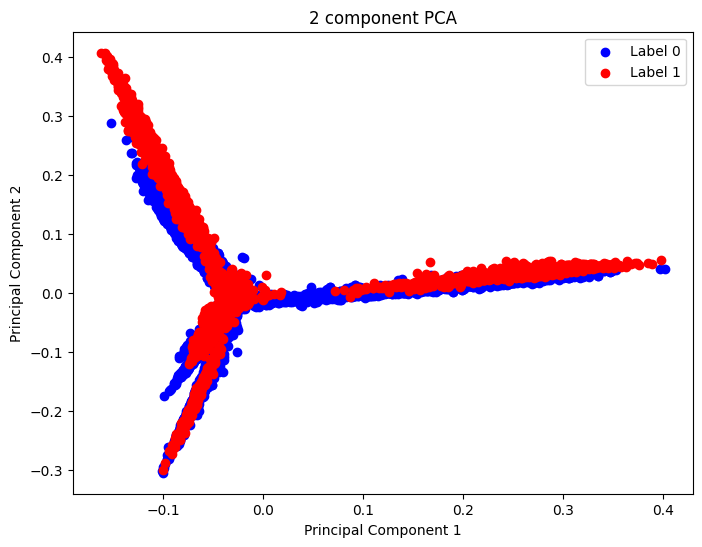

In [26]:
import matplotlib.pyplot as plt

y = train["label"]

# Plotting
plt.figure(figsize=(8, 6))
for label, color in zip([0, 1], ['blue', 'red']):
    plt.scatter(X_pca[y == label, 0], X_pca[y == label, 1], label=f'Label {label}', c=color)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2 component PCA')
plt.legend()
plt.show()